Imports

In [4]:
# pip instal mlxtend

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score,KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier
# import xgboost
# from xgboost import XGBClassifier

import random
random.seed(23)

In [32]:
df = pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
# df.head()

EDA

In [33]:
df.shape

(614, 13)

In [34]:
df.columns.values

array(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome',
       'LoanAmount', 'Loan_Amount_Term', 'Credit_History',
       'Property_Area', 'Loan_Status'], dtype=object)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
Loan_ID              614 non-null object
Gender               601 non-null object
Married              611 non-null object
Dependents           599 non-null object
Education            614 non-null object
Self_Employed        582 non-null object
ApplicantIncome      614 non-null int64
CoapplicantIncome    614 non-null float64
LoanAmount           592 non-null float64
Loan_Amount_Term     600 non-null float64
Credit_History       564 non-null float64
Property_Area        614 non-null object
Loan_Status          614 non-null object
dtypes: float64(4), int64(1), object(8)
memory usage: 62.4+ KB


In [36]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [37]:
cat_cols = ['Gender', 'Married','Education','Self_Employed','Property_Area','Credit_History','Dependents']
num_cols =['Loan_ID','ApplicantIncome', 'CoapplicantIncome','LoanAmount', 'Loan_Amount_Term'] 
# target = ['Loan_Status']
df[cat_cols].head(10)

,Gender,Married,Education,Self_Employed,Property_Area,Credit_History,Dependents
0,Male,No,Graduate,No,Urban,1.0,0
1,Male,Yes,Graduate,No,Rural,1.0,1
2,Male,Yes,Graduate,Yes,Urban,1.0,0
3,Male,Yes,Not Graduate,No,Urban,1.0,0
4,Male,No,Graduate,No,Urban,1.0,0
5,Male,Yes,Graduate,Yes,Urban,1.0,2
6,Male,Yes,Not Graduate,No,Urban,1.0,0
7,Male,Yes,Graduate,No,Semiurban,0.0,3+
8,Male,Yes,Graduate,No,Urban,1.0,2
9,Male,Yes,Graduate,No,Semiurban,1.0,1


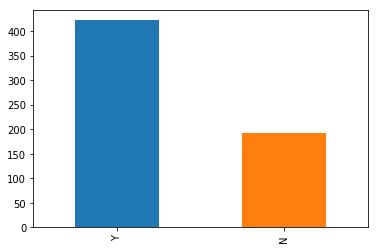

In [38]:
df['Loan_Status'].value_counts().plot(kind='bar');

In [39]:
print('Y% : {}'.format(df['Loan_Status'].value_counts()[0]/float(df.shape[0])))
print('N% : {}'.format(df['Loan_Status'].value_counts()[1]/float(df.shape[0])))

Y% : 0.6872964169381107
N% : 0.3127035830618892


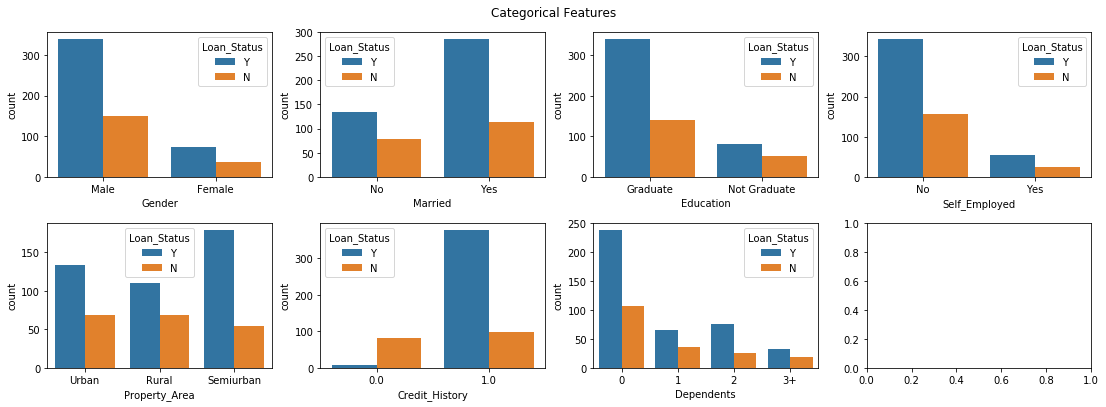

In [40]:
fig, ax = plt.subplots(2,4)
fig.set_size_inches(16,6)
fig.suptitle('Categorical Features')
for i in range(len(cat_cols)):
    row,col = int(i/4), i%4
    sns.countplot(x=cat_cols[i], hue="Loan_Status", data=df, ax=ax[row,col])
#     ax[row,col].set_title(cat_cols[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

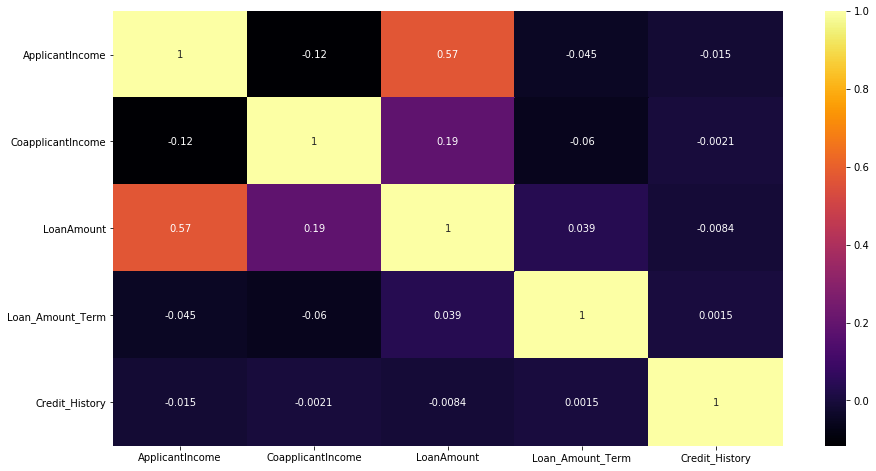

In [41]:
#correlation matrix
cm = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(cm, annot=True, cmap = 'inferno');

FE

In [19]:
#checking missing values
# sns.heatmap(df.isnull(),cmap='viridis',yticklabels=False);

In [42]:
df1 = df.copy()

In [47]:
df1.isnull().any()

Loan_ID                    False
Gender                     False
Married                    False
Education                  False
Self_Employed              False
ApplicantIncome            False
CoapplicantIncome          False
LoanAmount                 False
Loan_Amount_Term           False
Credit_History             False
Loan_Status                False
Rural_Property_Area        False
Semiurban_Property_Area    False
Urban_Property_Area        False
Dep_0                      False
Dep_1                      False
Dep_2                      False
Dep_3+                     False
dtype: bool

In [30]:
df1.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,1.0,0.0,0,1,0,5849,0.0,146.412162,360.0,1.0,Urban,1
1,LP001003,1.0,1.0,1,1,0,4583,1508.0,128.000000,360.0,1.0,Rural,0
2,LP001005,1.0,1.0,0,1,1,3000,0.0,66.000000,360.0,1.0,Urban,1
3,LP001006,1.0,1.0,0,0,0,2583,2358.0,120.000000,360.0,1.0,Urban,1
4,LP001008,1.0,0.0,0,1,0,6000,0.0,141.000000,360.0,1.0,Urban,1


In [44]:
#Encoding
df1['Gender'].replace({'Male':1,'Female':0},inplace=True)
df1['Married'].replace({'No':0,'Yes':1},inplace=True)
df1['Education'].replace({'Graduate':1,'Not Graduate':0},inplace=True)
df1['Self_Employed'].replace({'No':0,'Yes':1},inplace=True)
df1.Loan_Status.replace({'N':0,'Y':1},inplace=True)
df1['Dependents'].replace({"3+":3},inplace=True)

df1['Rural_Property_Area'] = (df1['Property_Area']=='Rural').astype('int')
df1['Semiurban_Property_Area'] = (df1['Property_Area']=='Semiurban').astype('int')
df1['Urban_Property_Area']= (df1['Property_Area']=='Urban').astype('int')

df1['Dep_0'] = (df1['Dependents']==0).astype('int')
df1['Dep_1'] = (df1['Dependents']==1).astype('int')
df1['Dep_2']= (df1['Dependents']==2).astype('int')
df1['Dep_3+']= (df1['Dependents']==3).astype('int')

df1.drop(['Dependents','Property_Area'],axis=1,inplace=True)
df1.head(10)

,Loan_ID,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Rural_Property_Area,Semiurban_Property_Area,Urban_Property_Area,Dep_0,Dep_1,Dep_2,Dep_3+
0,LP001002,1.0,0.0,1,0.0,5849,0.0,NaN,360.0,1.0,1,0,0,1,0,0,0,0
1,LP001003,1.0,1.0,1,0.0,4583,1508.0,128.0,360.0,1.0,0,1,0,0,0,0,0,0
2,LP001005,1.0,1.0,1,1.0,3000,0.0,66.0,360.0,1.0,1,0,0,1,0,0,0,0
3,LP001006,1.0,1.0,0,0.0,2583,2358.0,120.0,360.0,1.0,1,0,0,1,0,0,0,0
4,LP001008,1.0,0.0,1,0.0,6000,0.0,141.0,360.0,1.0,1,0,0,1,0,0,0,0
5,LP001011,1.0,1.0,1,1.0,5417,4196.0,267.0,360.0,1.0,1,0,0,1,0,0,0,0
6,LP001013,1.0,1.0,0,0.0,2333,1516.0,95.0,360.0,1.0,1,0,0,1,0,0,0,0
7,LP001014,1.0,1.0,1,0.0,3036,2504.0,158.0,360.0,0.0,0,0,1,0,0,0,0,1
8,LP001018,1.0,1.0,1,0.0,4006,1526.0,168.0,360.0,1.0,1,0,0,1,0,0,0,0
9,LP001020,1.0,1.0,1,0.0,12841,10968.0,349.0,360.0,1.0,0,0,1,0,0,0,0,0


In [46]:
#Handling missing values
#Imputing categorical features with mode
#numerical features with mean

df1.Gender.fillna(1.0,inplace=True)
df1.Married.fillna(1.0,inplace=True)

df1.Self_Employed.fillna(0,inplace=True)
df1.LoanAmount.fillna(df1.LoanAmount.mean(),inplace=True)
df1.Credit_History.fillna(1.0,inplace=True)
df1.Loan_Amount_Term.fillna(df1.Loan_Amount_Term.mean(),inplace=True)

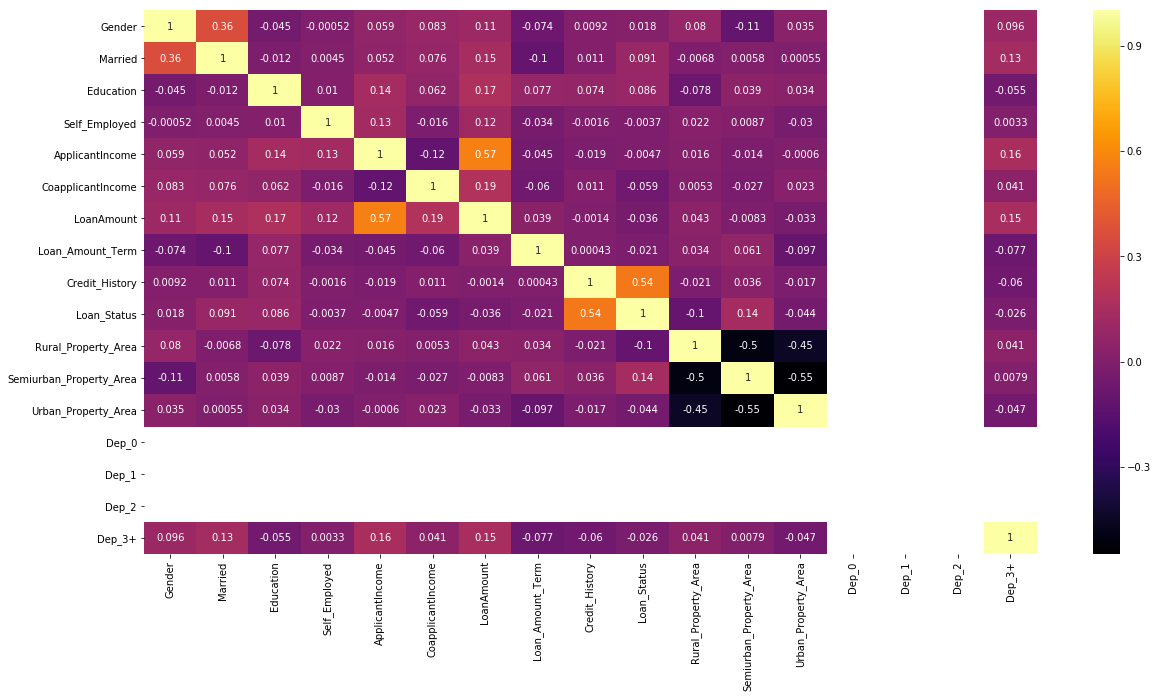

In [48]:
#correlation matrix
cm = df1.corr()
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, cmap = 'inferno');

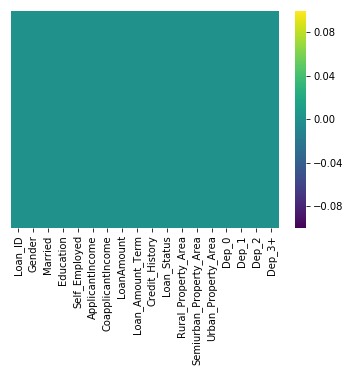

In [49]:
sns.heatmap(df1.isnull(),cmap='viridis',yticklabels=False); #confirming no missing values

In [50]:
#Scaling
to_scale = ['ApplicantIncome','CoapplicantIncome','LoanAmount']
scaler= RobustScaler()
df1[to_scale] = scaler.fit_transform(df1[to_scale])
# df1.head()

In [51]:
# # Removing Features 
df1.drop('Loan_ID',axis=1,inplace=True) #Does not imply any information
# df1.drop('CoapplicantIncome',axis=1,inplace=True) #Strongly negatively correlated with Target

In [ ]:
# df1.astype('float16').head()
# df1.apply(pd.to_numeric, errors='coerce')

Model

In [52]:
X = df1.drop('Loan_Status',axis=1)
y = df1['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train1, X_val, y_train1, y_val = train_test_split(X_train,y_train, test_size=0.10, random_state=42) #One Fold Cross Validation

In [53]:
#Random Forest 
clf = RandomForestClassifier()
clf.fit(X_train1,y_train1)
y_pred_val = clf.predict(X_val)
print ('Accuracy on validation set(RF): {}'.format(accuracy_score(y_pred_val,y_val))) #Accuracy on validation set

clf.fit(X_train,y_train)
y_pred_test = clf.predict(X_test)
print ('Accuracy on test set of training data(RF): {}'.format(accuracy_score(y_pred_test,y_test))) #Accuracy on test set of training data

Accuracy on validation set(RF): 0.76
Accuracy on test set of training data(RF): 0.7479674796747967


In [54]:
#Applying KFold to guage which algorithm performs better
seed = 7
scoring = 'accuracy'
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('RF2', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))


# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f" % (name, cv_results.mean())
    print(msg)

LR: 0.814776
RF2: 0.776082
DT: 0.698612


In [55]:
#Logistic Regression    
LR=LogisticRegression()
LR.fit(X_train1,y_train1)
y_pred_val = LR.predict(X_val)
print ('Accuracy on validation set(LR): {}'.format(accuracy_score(y_pred_val,y_val))) #Accuracy on validation set

LR.fit(X_train,y_train)
y_pred_test = LR.predict(X_test)
print ('Accuracy on test set of training data(LR): {}'.format(accuracy_score(y_pred_test,y_test))) #Accuracy on test set of training data

Accuracy on validation set(LR): 0.86
Accuracy on test set of training data(LR): 0.7886178861788617


In [56]:
#Stacking Ensemble
decision_tree_clf = DecisionTreeClassifier(max_depth=2,random_state=9) 
models = [LR, decision_tree_clf]
stacking_clf = StackingClassifier(classifiers = models,
                                 meta_classifier = decision_tree_clf)

stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7886178861788617

In [58]:
#Feture Selection method - RFE: Recurssive Feature Elimination
rfe1 = RFE(LR, 7)
rfe1 = rfe1.fit(X, y)
print ('Logistic Regression Feature Rankings:')
print(rfe1.ranking_)
print (('==')*40)

Logistic Regression Feature Rankings:
[ 3  1  1  4  5  1  2  7  1  1  1  1 10  9  8  6]


In [59]:
X.columns.values

array(['Gender', 'Married', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Rural_Property_Area',
       'Semiurban_Property_Area', 'Urban_Property_Area', 'Dep_0', 'Dep_1',
       'Dep_2', 'Dep_3+'], dtype=object)

In [60]:
#Logistic Regression with RFE top 10 features
x = df1.iloc[:,[1,2,5,8,9,10,11]]
y = df1['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
X_train1, X_val, y_train1, y_val = train_test_split(X_train,y_train, test_size=0.10, random_state=42)

LR_rfe = LogisticRegression()
LR_rfe.fit(X_train1,y_train1)
y_pred_val = LR_rfe.predict(X_val)
print ('Accuracy on validation set(LR_rfe): {}'.format(accuracy_score(y_pred_val,y_val)))

LR_rfe.fit(X_train,y_train)
y_pred_test = LR_rfe.predict(X_test)
print ('Accuracy on test set of training data(LR_rfe): {}'.format(accuracy_score(y_pred_test,y_test)))

Accuracy on validation set(LR_rfe): 1.0
Accuracy on test set of training data(LR_rfe): 1.0


In [61]:
#XgBoost
X = df1.drop('Loan_Status',axis=1)
y = df1['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train1, X_val, y_train1, y_val = train_test_split(X_train,y_train, test_size=0.10, random_state=42)

xgb = XGBClassifier()
xgb.fit(X_train1, y_train1)
y_pred_val = xgb.predict(X_val)
print ('Accuracy on validation set(xgb): {}'.format(accuracy_score(y_pred_val,y_val)))

xgb.fit(X_train,y_train)
y_pred_test = xgb.predict(X_test)
print ('Accuracy on test set of training data(xgb): {}'.format(accuracy_score(y_pred_test,y_test)))


NameError: name 'XGBClassifier' is not defined

In [ ]:
#XgBoost Adavnce1
X = df1.drop('Loan_Status',axis=1)
y = df1['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

xgb1 = XGBClassifier(n_estimators=100,learning_rate=0.15)
eval_set = [(X_test, y_test)]
xgb1.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False)

y_pred_test = xgb1.predict(X_test)
print ('Accuracy on test set of training data(xgb1): {}'.format(accuracy_score(y_pred_test,y_test)))

In [ ]:
#XgBoost Adavnce2
X = df1.drop('Loan_Status',axis=1)
y = df1['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train1, X_val, y_train1, y_val = train_test_split(X_train,y_train, test_size=0.10, random_state=42)

xgb2 = XGBClassifier(n_estimators=100,learning_rate=0.2)
eval_set1 = [(X_val, y_val)]
xgb2.fit(X_train1, y_train1, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set1, verbose=False)
y_pred_val = xgb2.predict(X_val)
print ('Accuracy on validation set(xgb2): {}'.format(accuracy_score(y_pred_val,y_val)))

eval_set2 = [(X_test, y_test)]
xgb2.fit(X_train,y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set2, verbose=False)
y_pred_test = xgb2.predict(X_test)
print ('Accuracy on test set of training data(xgb2): {}'.format(accuracy_score(y_pred_test,y_test)))

In [ ]:
#Positively Correlated features w.r.t Target
X = df1[['Gender', 'Married', 'Education','Credit_History','Semiurban_Property_Area']]
y = df1['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train1, X_val, y_train1, y_val = train_test_split(X_train,y_train, test_size=0.10, random_state=42)

xgb3 = XGBClassifier(n_estimators=640,learning_rate=0.001)
eval_set1 = [(X_val, y_val)]
xgb3.fit(X_train1, y_train1, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set1, verbose=False)
y_pred_val = xgb3.predict(X_val)
print ('Accuracy on validation set(xgb2): {}'.format(accuracy_score(y_pred_val,y_val)))

eval_set2 = [(X_test, y_test)]
xgb3.fit(X_train,y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set2, verbose=False)
y_pred_test = xgb3.predict(X_test)
print ('Accuracy on test set of training data(xgb2): {}'.format(accuracy_score(y_pred_test,y_test)))

***

Testing

In [ ]:
df2 = pd.read_csv('test_Y3wMUE5_7gLdaTN.csv')
# df2.head()
# df2.shape

In [ ]:
#Imputation
df2.Gender.fillna(1.0,inplace=True)
df2.Dependents.fillna(0,inplace=True)
df2.Self_Employed.fillna(0,inplace=True)
df2.LoanAmount.fillna(df1.LoanAmount.mean(),inplace=True)
df2.Credit_History.fillna(1.0,inplace=True)
df2.Loan_Amount_Term.fillna(df1.Loan_Amount_Term.mean(),inplace=True)
df2.Married.fillna(1.0,inplace=True)

#Encoding
df2['Gender'].replace({'Male':1,'Female':0},inplace=True)
df2['Married'].replace({'No':0,'Yes':1},inplace=True)
df2['Education'].replace({'Graduate':1,'Not Graduate':0},inplace=True)
df2['Self_Employed'].replace({'No':0,'Yes':1},inplace=True)
df2['Dependents'].replace({"3+":3},inplace=True,axis=1)

df2['Rural_Property_Area'] = (df2['Property_Area']=='Rural').astype('int')
df2['Semiurban_Property_Area'] = (df2['Property_Area']=='Semiurban').astype('int')
df2['Urban_Property_Area']= (df2['Property_Area']=='Urban').astype('int')
df2['Dep_0'] = (df2['Dependents']==0).astype('int')
df2['Dep_1'] = (df2['Dependents']==1).astype('int')
df2['Dep_2']= (df2['Dependents']==2).astype('int')
df2['Dep_3+']= (df2['Dependents']==3).astype('int')

df2.drop(['Dependents','Property_Area'],axis=1,inplace=True)

#Scaling
df2[to_scale] = scaler.fit_transform(df2[to_scale])
df2.drop('Loan_ID',axis=1,inplace=True)
# df2.drop('CoapplicantIncome',axis=1,inplace=True)

In [ ]:
#Random Forest
y_pred = clf.predict(df2)
y_pred = pd.DataFrame(y_pred)
y_pred.replace({1:"Y",0:'N'},inplace=True)
y_pred.to_csv('submit1.csv')
#Score - 0.7638888888888888.

In [ ]:
#Logistic Regression
y_pred_LR = LR.predict(df2)
y_pred_LR = pd.DataFrame(y_pred_LR)
y_pred_LR.replace({1:"Y",0:'N'},inplace=True)
y_pred_LR.to_csv('submit2.csv')
#Score - 0.7777777777777778.

In [ ]:
#Stacking_ensemble
y_pred_stacking = stacking_clf.predict(df2)
y_pred_stacking = pd.DataFrame(y_pred_stacking)
y_pred_stacking.replace({1:"Y",0:'N'},inplace=True)
y_pred_stacking.to_csv('submit3.csv')
#Score - 0.6597222222222222.

In [ ]:
#Logistic Regression with RFE top 10 features
test = df2.iloc[:,[1,2,5,8,9,10,11]]
y_pred_LR_rfe = LR_rfe.predict(test)
y_pred_LR_rfe = pd.DataFrame(y_pred_LR_rfe)
y_pred_LR_rfe.replace({1:"Y",0:'N'},inplace=True)
y_pred_LR_rfe.to_csv('submit4.csv')
#Score - 0.3333333333333333.

In [ ]:
#XgBoost Basic
y_pred_xgb = xgb.predict(df2)
y_pred_xgb = pd.DataFrame(y_pred_xgb)
y_pred_xgb.replace({1:"Y",0:'N'},inplace=True)
y_pred_xgb.to_csv('submit5.csv')
#Score - 0.7847222222222222.

In [ ]:
#XgBoost Advance1
y_pred_xgb1 = xgb1.predict(df2)
y_pred_xgb1 = pd.DataFrame(y_pred_xgb1)
y_pred_xgb1.replace({1:"Y",0:'N'},inplace=True)
y_pred_xgb1.to_csv('submit6.csv')
#Score - 0.7708333333333334.

In [ ]:
#XgBoost Advance2
y_pred_xgb2 = xgb2.predict(df2)
y_pred_xgb2 = pd.DataFrame(y_pred_xgb2)
y_pred_xgb2.replace({1:"Y",0:'N'},inplace=True)
y_pred_xgb2.to_csv('submit7.csv')
#Score - 0.7847222222222222.

In [ ]:
#Positively Correlated features w.r.t Target
y_pred_xgb3 = xgb3.predict(df2[['Gender', 'Married', 'Education','Credit_History','Semiurban_Property_Area']])
y_pred_xgb3 = pd.DataFrame(y_pred_xgb2)
y_pred_xgb3.replace({1:"Y",0:'N'},inplace=True)
y_pred_xgb3.to_csv('submit8.csv')
#Score - 0.7847222222222222.